# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dataclasses import dataclass
import typing

In [ ]:
#| hide
sns.set_style("white")
sns.set_style("ticks")

Create an instance of the class CalibrationModel by passing in the path to both your calibration data and your sample data. Next specify the name of your response variable and the nummber of test replicates you measured.

In [ ]:
#| export
class CalibrationModel:
    """ A class used to create a calibration curve for a given set of data.

    ...

    Attributes
    ----------
    x: pd.DataFrame
        A vector of data corresponding to the predictor of your calibration data e.g the concentration of standard solutions.

    y: pd.DataFrame
        A vector of data corresponding to the response variable of your calibration data.

    Methods
    -------

    fitmodel()
        Fits an ordinary least squares model to the data provided via the x, and y attributes of the class. Reports
        statistics of the fit additionally.

    inverse_prediction()
        Provides a prediction of the predictor variable corresponding to the value of the response variable provided
        e.g the concentration of a analyte solution is predicted based upon the response variable provided.

    linest_stats()
        Reports statistics one might expect to derive from performing a linest analysis using excel or sheets.

    calplot(xlab, ylab)
        Plots the fitted calibration curve with the regression formula and the r-squared value printed on the figure.

    """

    def __init__(self, x, y):
      
        self.x = x
        self.y = y
        self.slope = None
        self.intercept = None
        self.r_squared = None
        self.std_err = None
        self.test_replicates = None
        self.cal_line_points = self.x.shape[0]
        self.df_resid = self.cal_line_points - 2
        self.sr = None
        self.mean_replicate_observations = None
        self.average_response_cal_line = None
        self.fitted_values = None

    def fit_ols(self):
        self.slope, self.intercept, self.r_squared, self.std_err, _ = sp.stats.linregress(self.x, self.y)
    
    def calculate_fitted_values(self):
        self.fitted_values = self.slope * self.x + self.intercept

    def calculate_sse(self):
        self.calculate_fitted_values()
        return np.sum((self.fitted_values - self.y) **2)
    
    def calculate_syx(self):
        return np.sqrt((self.calculate_sse())/(len(self.x)-2))

    def get_t_value(self,alpha):
        return sp.stats.t.ppf(1 - alpha/2, self.df_resid)

    def calculate_uncertainty(self):
        return self.calculate_sxhat() * self.get_t_value(0.05)
        
    def calculate_hibbert_uncertainty(self, sr, test_repeats, y0, average_response_cal_line, sumsquares):
        return (1/self.slope) * np.sqrt(((sr**2)/test_repeats) + ((self.calculate_syx()**2)/self.cal_line_points) + 
                                                                   (((self.calculate_syx()**2)*((y0-average_response_cal_line)**2))/((self.slope**2)*(sumsquares))))
    
    def calculate_sxhat(self):
        return (self.calculate_syx() / self.slope) * np.sqrt(1 / self.test_replicates + 1 / self.cal_line_points) 
    
    def fit_model(self):
        # self.test_replicates = test_replicates
        self.fit_ols()
        # self.calculate_uncertainty()
        self.tabulate_results()

    def inverse_prediction(self, unknown):

        if len(unknown) > 1:
            y0 = np.mean(unknown)
            sr = np.std(unknown)
            test_repeats = len(unknown)
            average_response_cal_line = np.mean(self.y)
            sumsquares = np.sum((self.x - self.x.mean())**2)

            pred =  (y0 - self.intercept)/self.slope
        
            return f"{pred} ± {self.calculate_hibbert_uncertainty(sr=sr, y0=y0, test_repeats=test_repeats, average_response_cal_line=average_response_cal_line, sumsquares=sumsquares) * self.get_t_value(0.05)}"
        else:
            y = unknown[0]
            pred = (y - self.intercept)/self.slope
            return f"{pred} ± {self.calculate_uncertainty()}"

    def tabulate_results(self):
        print(f"Calibration curve")
        print(f"R2 = {self.r_squared}")
        print(f"Slope = {self.slope}")
        print(f"Intercept = {self.intercept}")
        # print(f"Uncertainity = {self.calculate_uncertainty()}")
        # print(f"Prediction = {self.inverse_prediction()}")

    def linest_stats(self):
        """
        This method calculates and produces the stats you might expect to derive from a LINEST analysis
        performed using excel or sheets.
        """

        self.calculate_fitted_values()

        df = self.cal_line_points - 2
       
        regression_ss = np.sum((self.fitted_values - self.y.mean())**2)

        residual_ss = np.sum((self.y - self.fitted_values)**2)

        uncertainty_in_slope = np.sqrt(residual_ss/(df*np.sum((self.x - self.x.mean())**2)))

        uncertainty_in_intercept = uncertainty_in_slope * np.sqrt(np.sum(self.x**2)/df)
        
        std_error_of_regression = np.sqrt(residual_ss/df)
    
        F = regression_ss/(std_error_of_regression**2)

        # tabulate statistics in a pandas dataframe
        stats = pd.DataFrame({"Slope": self.slope,
                                "Intercept": self.intercept,
                                "Uncertainty in slope": uncertainty_in_slope,
                                "Uncertainty in intercept": uncertainty_in_intercept,
                                "Standard error of regression": std_error_of_regression,
                                "F-statistic": F,
                                "Degrees of freedom": df,
                                "Regression sum of squares": regression_ss,
                                "Residual sum of squares": residual_ss}, index=[0])
        return stats



    def calplot(self, xlab, ylab):

        """
        Plots the fitted calibration curve with the regression formula and the r-squared value printed on the figure.

        Parameters
        ----------
        xlab: str
            Label for the x-axis.

        ylab: str
            Label for the y-axis.
        """

        fig, ax = plt.subplots()
        sns.regplot(x=self.x, y=self.y, ci=None)
        ax.set_title("Calibration curve")
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.annotate(f"y = {self.slope: 3f}x + {self.intercept: 3f}", xy=(0.1, 0.9), xycoords="axes fraction")
        ax.annotate(f"R-squared = {self.r_squared: 3f}", xy=(0.1, 0.8), xycoords="axes fraction")
        
        plt.show()

## Tests

In [ ]:
def generate_test_data(slope, intercept):
        x = np.linspace(1, 10, num=5)
        y = intercept + x * slope
        df = pd.DataFrame({'concentration': x, "abs": y})
        return df
def generate_sample_data():
    x = np.array(['unknown1', 'unknown2'])
    y = np.array([13.75, 20.50])
    df = pd.DataFrame({'sample': x, "abs": y})
    df = df.set_index('sample')
    return df


# test_data = generate_test_data(3, 4)
# sample_data = generate_sample_data()

test_data = pd.DataFrame({'concentration': [0.2, 0.05, 0.1, 0.8, 0.6, 0.4], "abs": [0.221, 0.057, 0.119, 0.73, 0.599, 0.383]})
sample_data = pd.DataFrame({'unknown': [0.490, 0.471, 0.484, 0.473, 0.479, 0.492]})

Create a calibration model object by passing in the predictor and response data for your calibration curve.

In [ ]:
cal = CalibrationModel(x=test_data['concentration'], y=test_data['abs'])

Call the fit_model method and the parameters of the fit will be printed to the screen.

In [ ]:
cal.fit_model()

Calibration curve
R2 = 0.9976282521058687
Slope = 0.9044109330819979
Intercept = 0.027419415645617395


The individual parameters can be accessed by selecting the parameter name with dot notation. For example, to access the slope of the calibration curve, use the following code:

```python
cal.slope
```

In [ ]:
print(f"Slope: {cal.slope}")

Slope: 0.9044109330819979


Calling the method `.linest_stats()` will produce a pandas dataframe of the same statistical output you might expect when performing a linest analysis using excel or sheets.

In [ ]:
cal.linest_stats()



,Slope,Intercept,Uncertainty in slope,Uncertainty in intercept,Standard error of regression,F-statistic,Degrees of freedom,Regression sum of squares,Residual sum of squares
0,0.904411,0.027419,0.0312,0.017178,0.020745,840.261133,4,0.361606,0.001721


Inverse predictions can be called via the `.inverse_prediction` method. Call the method and pass a list of values you would like to predict. Note, even if you only have a single sample still pass the sample in a list.

In [ ]:
cal.inverse_prediction(sample_data['unknown'])

'0.5020733029033536 ± 0.031053583676141718'

The `.calplot` method will plot the calibration curve.

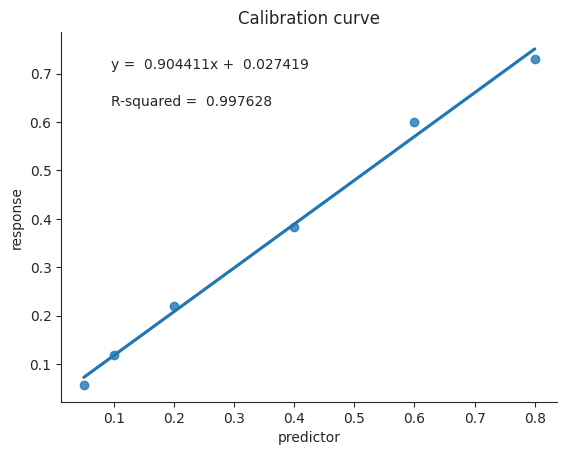

In [ ]:
cal.calplot(xlab='predictor', ylab='response')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()